# Сборный проект - 1: Исследование рынка компьютерных игр
###  3 поток, 2 когорта
#### Друзык Роман Богданович
*Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Не важно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».*

***
***

## Откроем файл с данными и изучим общую информацию.

*Загрузим необходимые библиотеки*

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.axes.Axes.pie
matplotlib.pyplot.pie
import seaborn as sns
import numpy as np
import math
from scipy import stats as st

*Откроем файл с данными и изучим его*

In [2]:
pd.set_option('display.max_columns', 50)
data = pd.read_csv('/datasets/games.csv')

In [3]:
data.head(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


***
***


## Подготовим данные к дальнейшему анализу

*Посмотрим на типы данных в толбцах*

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


*Переименуем столбцы в нижний регистр.*

In [5]:
data.columns = ['name', 'platform', 'year_of_release', 
                'genre', 'NA_sales', 'EU_sales', 'JP_sales', 
                'other_sales', 'critic_score', 'user_score', 'rating']

*Проверим, есть ли пропущенные значения*

In [6]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

*Значения с пропущеным годом релиза, названием и жанром мы восстановить не сможем, поэтому удалим данные события*

In [7]:
data = data.dropna(subset=['year_of_release', 'name', 'genre']).reset_index()

*Все пропуски в оставшихся столбцах critic_score, user_score, rating заменим на 0, для удобства дальнейшей обработки*

In [8]:
data['critic_score'] = data['critic_score'].fillna(0)
data['user_score'] = data['user_score'].fillna(0)
data['rating'] = data['rating'].fillna(0)

*Посмотрим на распределение рейтингов критиков*

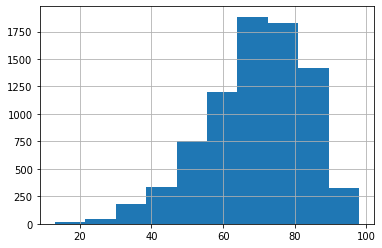

In [9]:
data.query('critic_score>0').critic_score.hist()

*и пользователей, но столбец с рейтингом пользователей имеет строковый формат, поэтому посмотрим через value_counts*

In [10]:
data.user_score.value_counts().head(3)

0      6605
tbd    2376
7.8     322
Name: user_score, dtype: int64

***

*Можем заметить, что большое количество значений у величины tbd, что обозначает to be determined. 
Количество данных значений довольно существенно (примерно 15%), удалить из анализа такое большое количество было бы не корректным.
Попробуем обработать данный момент*

***Для обработки данной аномалии предположим следующую гипотезу:***
*У нас имеется оценка критиков и оценка пользователей, часто данные оценки не совпадают. 
Предполагаем, что для каждого игрового жанра разница между средней оценкой критика и средней оценкой ползователей - разная.
Посчитаем среднюю оценку критиков по каждому жанур, а так же среднюю оценку пользователей по каждому жанру.
Далее найдем среднее отклонение в оценках по кажому жанру и возьмем его как основу для дальнейших расчетов.
Далее в событиях, у которых имеется оценка критика, но не имеется оценки пользователей, добавим/отнимем среднюю оценку пользователей в жанре.
Аналогичным образом поступим и с оценкой пользователей, при отсутствии оценки критиков*

*В событиях, у которых отсутствует оба признака - оставим 0, никаким образом не заменяя пропуски, так как это действие сильно исказит картину для анализа (это будет фантазия, далекая от объективной оценки)*

***

*Сгруппируем наши данные, чтобы получить таблицу со средней оценкой критиков по жанрам. Для дальнейшего корректного результата, нормируем данную оценку к 10 (как у оценки пользователя).*

In [11]:
critic_score_mean = (
    data.query('critic_score>0')
    .groupby('genre')
    .agg({'critic_score': 'mean'})
    .reset_index())

critic_score_mean['critic_score'] = critic_score_mean['critic_score'] / 10

*Уберем из столбца user_mean строковые значения tbd*

In [12]:
user_score_mean = data.query('user_score!="tbd"')

*Преобразуем столбец user_score в наборе user_mean в числовой вид*

In [13]:
user_score_mean['user_score'] = pd.to_numeric(user_score_mean['user_score'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


*Сгруппируем наши данные, чтобы получить таблицу со средней оценкой пользователей по жанрам.*

In [14]:
user_score_mean = user_score_mean.query('user_score>0').groupby('genre').agg({'user_score': 'mean'}).reset_index()

*Объеденим данные в единную таблицу*

In [15]:
std_score = user_score_mean.merge(critic_score_mean)

*В отдельный столбец запишем разницу между средней оценкой пользователей и критиков по разным жанрам*

In [16]:
std_score['difference_values'] = std_score['user_score'] - std_score['critic_score']

*Создадим словарь с жанрами и средним отклонением оценки*

In [17]:
std_dict = {x[0] : x[1] for x in std_score.drop(['user_score', 'critic_score'], axis=1).itertuples(index=False)}

*Для корректного анализа приведем оценку критиков к единому масштабу с оценкой пользователей: разделим на 10*

In [18]:
data['critic_score'] = data['critic_score'] / 10

*Напишем функцию, которая будем менять значение в столбце user_score исходного набора данных, при условии critic_score не равен нулю и user_score равен tbd*

In [19]:
def convert_user_score(row):
    if ((row['critic_score']!=0) and (row['user_score']=='tbd')) or ((row['critic_score']!=0) and (row['user_score']=='0')):
        revenue = row['critic_score'] + std_dict[row['genre']]
        return revenue
    else:
        revenue = row['user_score']
        return revenue

*Примениф функцию к столбцу user_score*

In [20]:
data['user_score'] = data.apply(convert_user_score, axis=1)

*Мы заполнили все значения tbd, где была оценка критиков*
*Теперь удалим оставшиеся tbd, заменив их на 0, так как рейтинги - это данные, которые либо есть, либо их нет. 
Заполнение этих пропусков очень исказит картину, чего не хотелось бы, для корректности дальнейщего анализа.
Аналогичным образом поступим и с пропусками в столбце rating, не будем выдумывать рейтинов возрастных категорий игр, которых нет.
В дальнейшем анализе, если будет необходимо анализировать только финансовые показатели, то будем включать данные события в анализ, при анализе событий в признаках рейтингов будем исключать из анализа значения равные 0, для объективности картины*

In [21]:
#Поменяем все tbd на нули
data.loc[data['user_score']=='tbd', 'user_score']=0

*Поменяем формат столбца user_score на float*

In [22]:
data['user_score'] = data['user_score'].astype('float').round(1)

In [23]:
def convert_critic_score(row):
    if ((row['user_score']!=0) and (row['critic_score']==0)):
        revenue = row['user_score'] - std_dict[row['genre']]
        if revenue<0:
            return 0
        return revenue
    else:
        revenue = row['critic_score']
        return revenue

*Применим функцию к столбцу critic_score*

In [24]:
data['critic_score'] = round(data.apply(convert_critic_score, axis=1), 1)

*Посмотрим на значения в столбце rating*

In [25]:
data.rating.value_counts()

0       6676
E       3921
T       2905
M       1536
E10+    1393
EC         8
K-A        3
AO         1
RP         1
Name: rating, dtype: int64

*Можно заметить что есть ранги рейтинга, которые не входят в градацию ESRB, а именно EC, K-A, A0, RP.
Удалим эти события из таблицы (их количество не значительно)*

In [26]:
data = data.loc[data['rating'] != 'EC']
data = data.loc[data['rating'] != 'K-A']
data = data.loc[data['rating'] != 'AO']
data = data.loc[data['rating'] != 'RP']

*Добавим в суммарную таблицу столбец с глобальными продажами по всем регионам*

In [27]:
data['global_sales'] = data.NA_sales + data.EU_sales + data.JP_sales

*Столбец year_of_release поменяем тип на целочисленный*

In [28]:
data.year_of_release = data.year_of_release.astype('int')

*Посмотрим на суммарную таблицу*

In [29]:
data.head()

,index,name,platform,year_of_release,genre,NA_sales,EU_sales,JP_sales,other_sales,critic_score,user_score,rating,global_sales
0,0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,7.6,8.0,E,74.09
1,1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,0.0,0.0,0,39.47
2,2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,8.2,8.3,E,32.23
3,3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,8.0,8.0,E,29.82
4,4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,0.0,0.0,0,30.38


*На этом нашу предобработку данных мы завершаем. Перейдем к выводам.*

### *Вывод*
*Мы проведи предобработку данных, удалили события с отсутствующими годами выпуска (1,6% данных), а так же заполнили пропуски в рейтингах пользователей и критиков, на основе среднего отклонения оценок в жанре. 
Отсутствие рейтинговой категоризации оставили таким как есть, без предобработки, чтобы не искажать данные.
Для себя понимаем что система рейтингов ESRB существует с 1994 года, все игры ранее не классифицировались, и практика выставления рейтинговых оценок критиками и пользователями так же сформировалась не моментально, а развивалась с годами и поэтому присутствуют пропуски по всем годам.
Анализировать данные будем исходя из допущений, что если нужна будет оценка без влияния рейтинга, то будем отсекать датасет по параметру 0 в оценках и не будем анализировать события с 0 рейтингами, при анализе финансовых составляющиз будем использовать вессь набор данных.*

***
***

## Проведем исследовательский анализ данных.

#### *Посмотрим, сколько игр выпускалось в разные годы.*

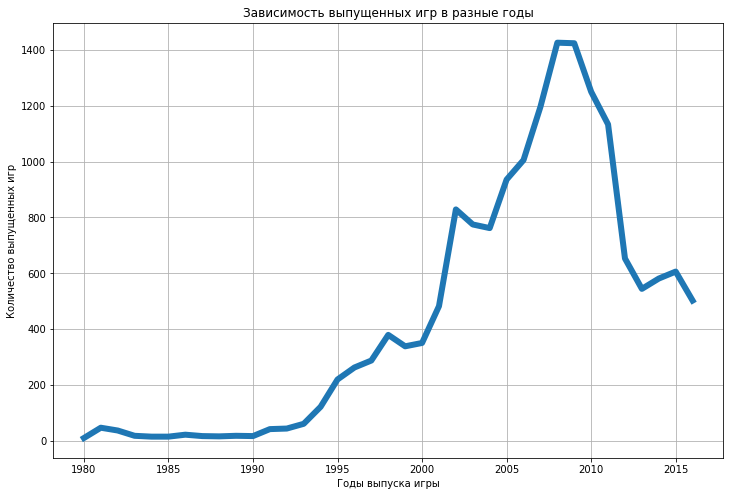

In [30]:
release_per_year = data.groupby('year_of_release').agg({'name': 'count'}).reset_index()
x = release_per_year.year_of_release
y = release_per_year.name
plt.figure(figsize=(12, 8))
plt.plot(x, y, linewidth=6.0)
plt.grid(True)
plt.title('Зависимость выпущенных игр в разные годы')
plt.xlabel('Годы выпуска игры')
plt.ylabel('Количество выпущенных игр')
plt.show()

*По данному графику мы видим что индустрия компьютерных игр очень бурно начала развиваться с начала 90х годов (примерно 1993 - появление на рынке консолей, которые стали массовыми хитами) и начиная с начала нулевых годов XXI века мы наблюдаем взрывной рост темпов производства игр, вплоть до 2008 года.
Мировой экономический кризис, который начался в 2008 году очень сильно сказался и на рынке компьютерных игр, в результате которого объемы производства начал сильно снижаться. Падение производства остановилось лишь 2013 году, с котрого наметилась тенденция к восстановлению.
Так как данные в нашем наборе за 2016 год не за весь год, то мы видим провал объема производства по этому году - не принимаем его во внимание.*

***

#### *Посмотрим, как менялись продажи по различным платформам.*

*Определим платформы с наибольшими суммарными продажами и построим гистограмму.*

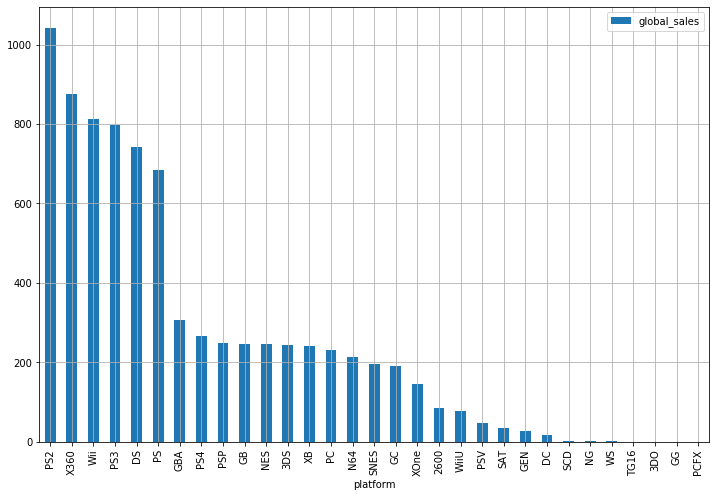

In [31]:
top_sales_platform = (data
                      .pivot_table(index='platform', 
                                   values='global_sales', 
                                   aggfunc='sum')\
                      .sort_values('global_sales', ascending=False)\
                      .reset_index())
top_sales_platform.plot('platform', 'global_sales', kind='bar', figsize=(12, 8), grid=True)

*Из гистограммы видно, что по объемам глобальных продаж явно выделяется 6 платформ.
Построим распределение глобальных продаж по данным платформам по годам*

In [32]:
#Упакуем список названий ТОП-6 платформ в словарь
top6_list = {x[0] for x in top_sales_platform.head(6).itertuples(index=False)}

*Отсортируем нашу таблицу таким образом, чтобы получить срез ТОП-6 платформ ираспределение их продаж по годам*

In [33]:
top6_sales_per_years = (data
                        .query('platform in @top6_list')
                        .pivot_table(index='year_of_release', 
                                     columns='platform', 
                                     values='global_sales', 
                                     aggfunc='sum')
                        .fillna(0))

*Посмотрим на получившийся срез*

In [34]:
top6_sales_per_years.head(6)

platform,DS,PS,PS2,PS3,Wii,X360
year_of_release,,,,,,
1985,0.02,0.00,0.0,0.0,0.0,0.0
1994,0.00,5.63,0.0,0.0,0.0,0.0
1995,0.00,34.00,0.0,0.0,0.0,0.0
1996,0.00,87.28,0.0,0.0,0.0,0.0
1997,0.00,128.30,0.0,0.0,0.0,0.0
1998,0.00,160.44,0.0,0.0,0.0,0.0


*Построим графики распределения глобальных продаж по годам для ТОП-6 платформ*

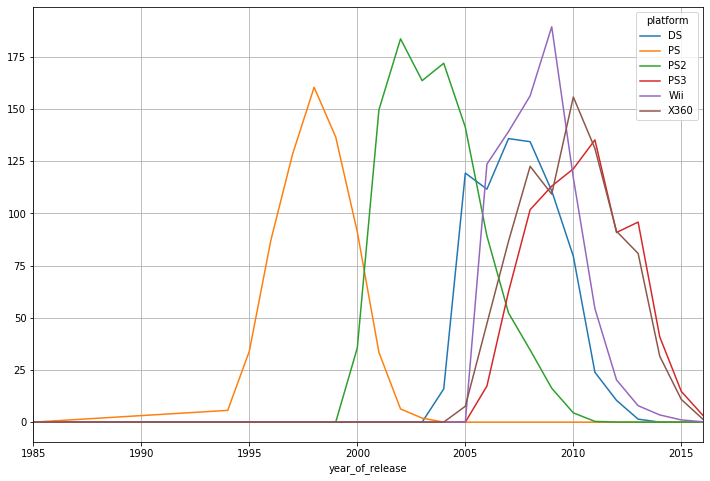

In [35]:
top6_sales_per_years.plot(figsize=(12, 8), grid=True) 

*По данному графику можно оценить средний срок жизни платформ - примерно **10 лет** живет каждая платформа.*

*Закрепим данный срок - как актуальный срок жизни платформы и будем использовать полученные знания в дальнейшем анализе*

***

#### Определим потенциально прибыльне платформы

*Для данного определения зафиксируем предыдущий результат, что срок жизни платформы - 10 лет.* 

*Так же мы знаем, что данные за 2016 год не полные (в разрезе объемов продаж), так что не будем на данном этапе использовать его для анализа.*

*Построим график зависимости глобальных продаж по различным платформам, начиная с 2005 года и найдем те позиции, продажи по которым не падают, а растут - это и будут перспективные, потенциально-прибыльные платформы.*

In [36]:
promising_platform_sum = (data
                      .query('2005<=year_of_release<2016')
                      .pivot_table(index='year_of_release', 
                                   columns='platform', 
                                   values='global_sales', 
                                   aggfunc='sum')
                      .fillna(0))

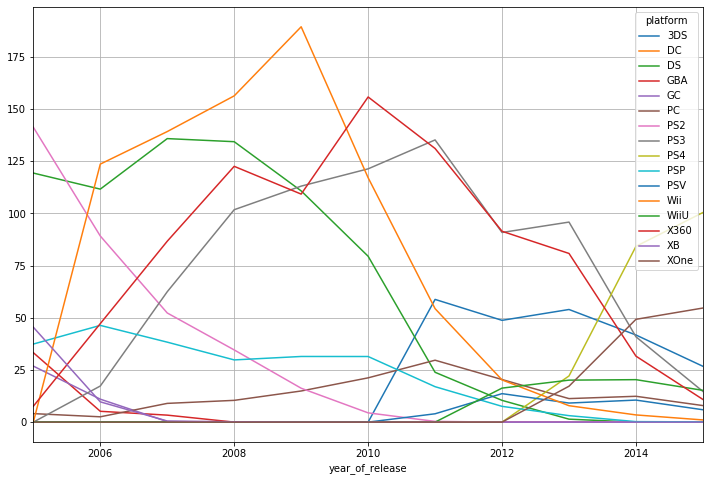

In [37]:
promising_platform_sum.plot(figsize=(12, 8), grid=True) 

*По данному графику мы видим явно, что только 2 платформы, которые растут - **PlayStation4** и **XBoxOne**. Все остальные консоли,снижаются в глобальных продажах.*

*Продажи **PlayStation4** и **XBoxOne** начались в один год - с 2012. Учтем это знание для анализа платформ в дальнейшем*

*Данные платформы пришли на замену PlayStation3 и XBox360 и, на момент проведения данного анализа, уже обогнали по уровню продаж платформы предыдущего поколения*

***

#### *Построим графики «ящик с усами»*

*В первую очередь посмотрим на распределение продаж видеоигр на разных платформах (популярных за последние 10 лет) в разрезе разных годов*

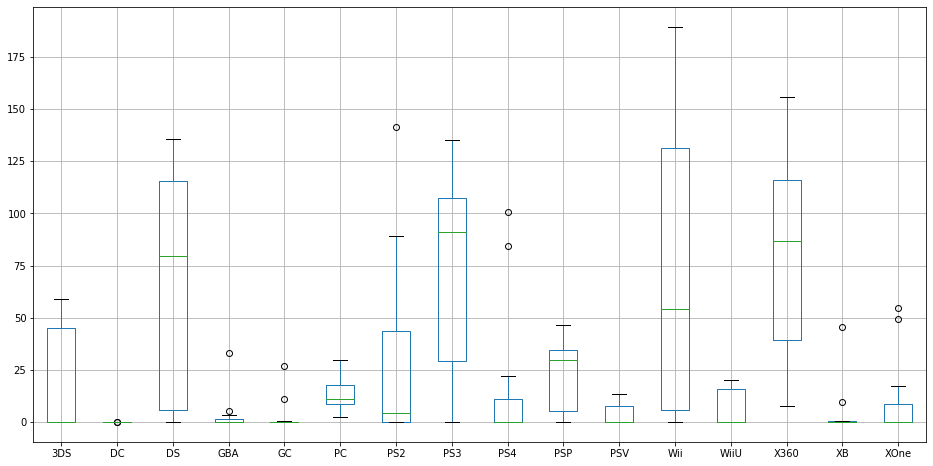

In [38]:
promising_platform_sum.boxplot(figsize=(16, 8))

*Теперь оценим распределение средних продаж видеоигр на разных платформах (популярных за последние 10 лет) в разрезе разных годов. Причем можно заметить, что объем продаж перспективных платформ (PlayStation4 и XBoxOne) на данном временном промежутке не являются доминантными, а так же видно что продажи на PlayStation4 более чем вдвое превосходит объем продаж на XBoxOne.*

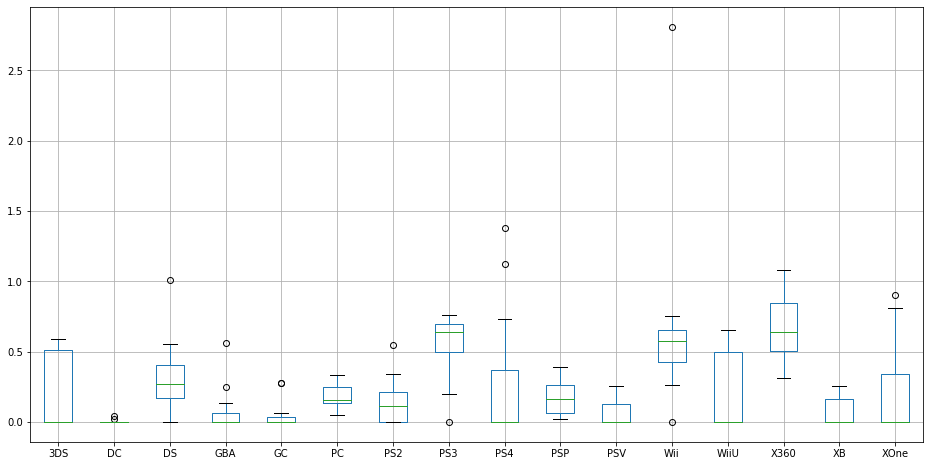

In [39]:
promising_platform_mean = (data
                      .query('2005<=year_of_release<2016')
                      .pivot_table(index='year_of_release', 
                                   columns='platform', 
                                   values='global_sales', 
                                   aggfunc='mean')
                      .fillna(0))
promising_platform_mean.boxplot(figsize=(16, 8))

*Из данного boxplot мы можем увидеть распределение объемов продаж. Явно выделяются DS, PS3, Wii, X360, у которых самые большие объемы продаж в исследуемом периоде*

*По данному ящику видим аналогичную картину. Явно выделяются DS, PS3, Wii, X360, у которых самые большие средние продажи в исследуемом периоде. При анализе свечей по перспективным платформам мы видим что глобальной разницы по средним объемам продаж не наблюдается*

***

*Построим boxplot с распредлением глобальных продаж каждой игры на двух перспективных платформах*

In [40]:
sales_two_platforms = (data
                       .query('(platform=="PS4" or platform=="XOne") and (global_sales>0)')
                       .pivot_table(index='name', 
                                    columns='platform', 
                                    values='global_sales')
                       .fillna(0))
sales_two_platforms.head()

platform,PS4,XOne
name,,
7 Days to Die,0.12,0.05
Adventure Time: Finn & Jake Investigations,0.08,0.05
Aegis of Earth: Protonovus Assault,0.02,0.00
Agatha Christie's The ABC Murders,0.02,0.01
Akiba's Trip: Undead & Undressed,0.09,0.00


(0, 4)

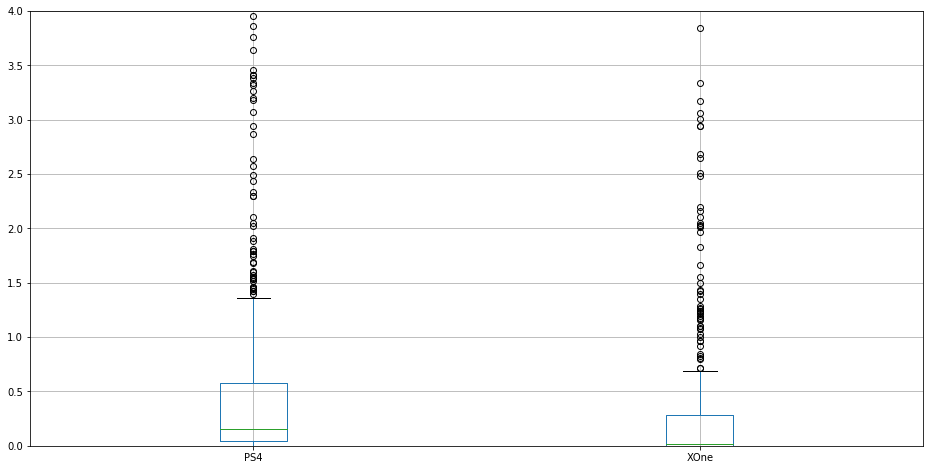

In [41]:
'''
Уберем из анализа данные, продажи по которым составляют 0, чтобы не учитывать игры, 
которые вышли на одной платформе и не вышли на другой
'''
sales_two_platforms.query('PS4>0 or XOne>0').boxplot(figsize=(16, 8))
plt.ylim(0, 4)

*По данным ящикам мы видим что продажи на PS4 в два раза выше, чем на XOne. Все выбросы - это игры, которые показывают большие продажи, по сравнению с общей массой выпускаемых игр (Хиты)*

In [42]:
print('Средние продажи на PS4: {:.2f}'.format(sales_two_platforms.PS4.mean()))
print('Средние продажи на XOne: {:.2f}'.format(sales_two_platforms.XOne.mean()))

Средние продажи на PS4: 0.63
Средние продажи на XOne: 0.34


*Средние продажи на разных платформах так же отличаются почти вдвое. По проведенному анализу мы можем сделать вывод, что PlayStation4 более привлекательная платформа для выпуска игр, чем XOne.*

***

#### *Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков.*

*Посмотрим сначала как зависят друг от друга продажи и отзывы на PS4 *

In [43]:
data_score = (data[['platform', 'global_sales', 'critic_score', 'user_score']]
              .query('(platform=="PS4" or platform=="XOne") and global_sales!=0 and (critic_score!=0 or user_score!=0)'))

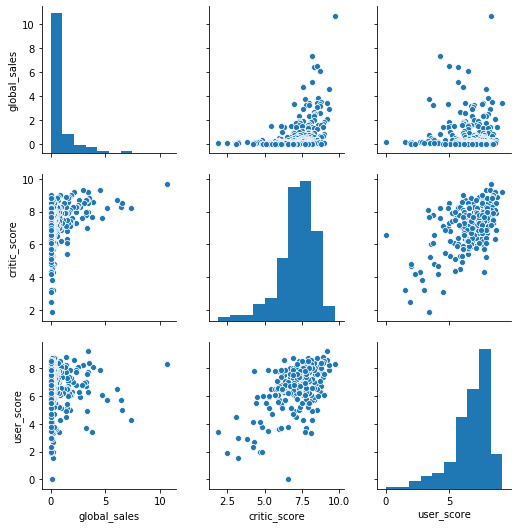

In [44]:
sns.pairplot(data_score.query('platform=="PS4"'))

In [45]:
data_score.query('platform=="PS4"').corr()

,global_sales,critic_score,user_score
global_sales,1.000000,0.403536,-0.022702
critic_score,0.403536,1.000000,0.557079
user_score,-0.022702,0.557079,1.000000


*На PS4 мы наблюдаем что имеется слабая зависимость между глобальными продажами и оценками критиков, но мы не можем утверждать что продажы зависят от оценок критиков или оценки критиков зависят от продаж - мы можем утверждать только о слабой зависимости параметров друг от друга*

*Так же мы видим наличие зависимости между оценками критиков и оценками пользователей, но она не такая сильная (отличается от субъективных ожиданий) и абсолютно не просматривается зависимости между глобальными продажами и оценками пользователей.*

***

*Посмотрим сначала как зависят друг от друга продажи и отзывы на XOne*

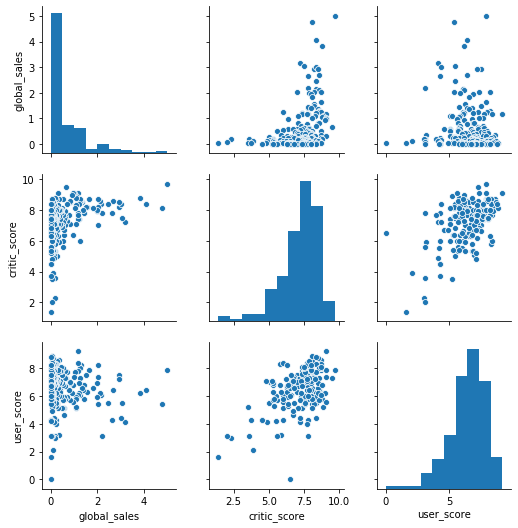

In [46]:
sns.pairplot(data_score.query('platform=="XOne"'))

In [47]:
data_score.query('platform=="XOne"').corr()

,global_sales,critic_score,user_score
global_sales,1.000000,0.410339,-0.043819
critic_score,0.410339,1.000000,0.525766
user_score,-0.043819,0.525766,1.000000


*При анализе взаимосвязей между параметрами мы видим, что картина на двух платформах очень схожа. Взаимосвязи между глобальными продажами и оценками кртииков и пользователей очень похожи на двух платформах.*

***

*Посмотрим сначала как зависят друг от друга продажи и отзывы на других платформах, популярных в последние 10 лет*

*Вытащим список популярных платформ в словарь*

In [48]:
platform_10year_dict = ({x[0] for x in promising_platform_sum
                         .T
                         .reset_index()
                         .query('platform!="PS4" and platform!="XOne"')
                         .itertuples(index=False)})

data_other_score = (data[['platform', 'global_sales', 'critic_score', 'user_score']]
              .query('platform in @platform_10year_dict and global_sales!=0 and (critic_score!=0 or user_score!=0)'))

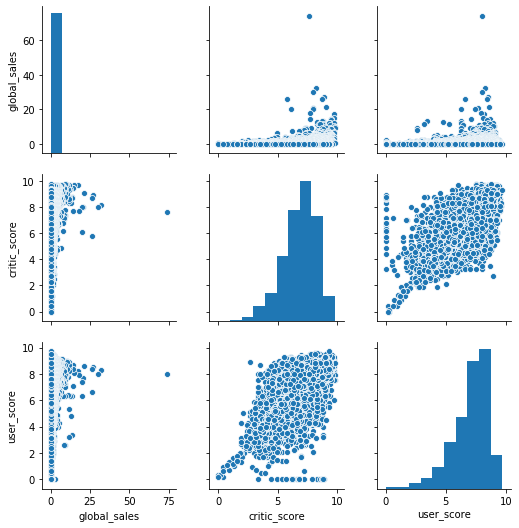

In [49]:
sns.pairplot(data_other_score)

In [50]:
data_other_score.corr()

,global_sales,critic_score,user_score
global_sales,1.000000,0.216145,0.103594
critic_score,0.216145,1.000000,0.664498
user_score,0.103594,0.664498,1.000000


*Из данного анализа мы видим, что на других приставках, популярных за последние 10 лет, взаимосвязь между продажами и оценками критиков/пользователей очень сильно слабая, практически никакой взаимосвязи нет*

#### *Вывод*

*При исследовании взаимосвязи между продажами и оценками критиков/пользователей мы выяснили что на перспективных платформах PS4 и XOne слабая взаимосвязь между оценкой критиков и продажами имеется, в то время как взаимосвязь продаж с оценками пользователей практически отсутствует. Это означает, что пользователи покупают или не покупают игру, без оглядки на мнение критиков и сумарные продажи игры, ориентируются только на свои субъективные оценки.
Так же мы видим, что на других платформах, популярных в последние 10 лет, такая взаимосвязь практически отсутствует.* 

***

#### *Посмотрим на общее распределение игр по жанрам на всех популярных платформах за последние 10 лет*

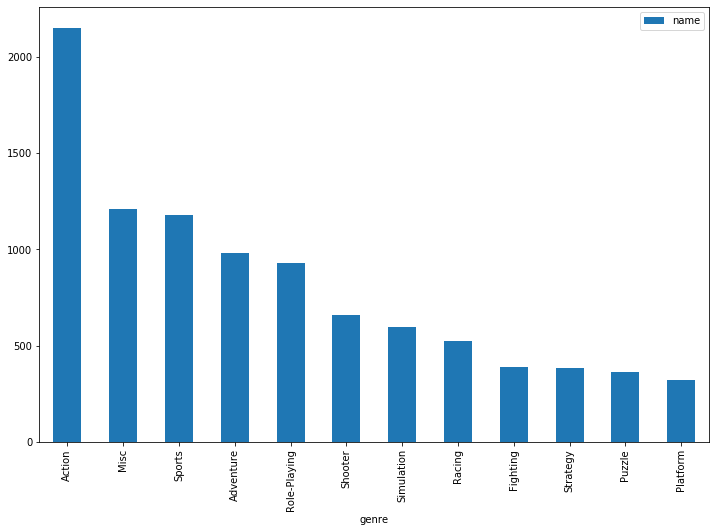

In [51]:
(data
 .query('platform in @platform_10year_dict and year_of_release>2005')
 .groupby('genre')
 .count()
 .reset_index()
 .sort_values(by='name', 
              ascending=False)
 .plot(x='genre', 
       y='name', 
       kind='bar', 
       figsize=(12, 8)))

*По данному распределению видно, что на популярных платформах за последние лет самым выпускаемым жанром является Action, который по количеству выпущенных игр превышает ближайший жан почти в 2 раза. Далее следуют Misc, Sports, Adventures.*

*А теперь посмотрим на данный срез с точки зрения глобальных продаж по жанрам*

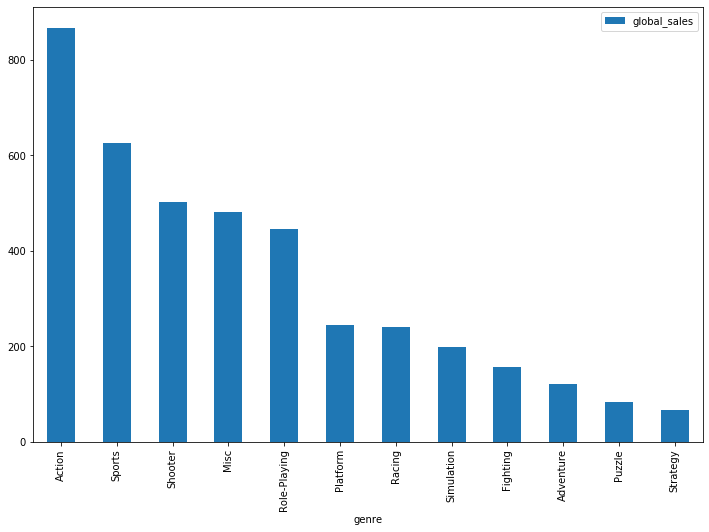

In [52]:
(data
 .query('platform in @platform_10year_dict and year_of_release>2005')
 .pivot_table(index='genre', 
              values='global_sales', 
              aggfunc='sum')
 .sort_values('global_sales', 
              ascending=False)
 .reset_index().plot(x='genre', 
       y='global_sales', 
       kind='bar', 
       figsize=(12, 8)))

*По сумме глобальных продаж ситуация совсем не коррелирует с количеством выпущенных игр. Хоть на первом месте так и остается жанр Action, но вот 2-5 места распределены совсем иначе - много покупают игр в жанре Sports и Shooters. А вот Adventures, не смотря на большое количество выпущенных игр, покупают их не так хорошо.*

***

#### *Посмотрим на общее распределение игр по жанрам на PS4 и XOne*

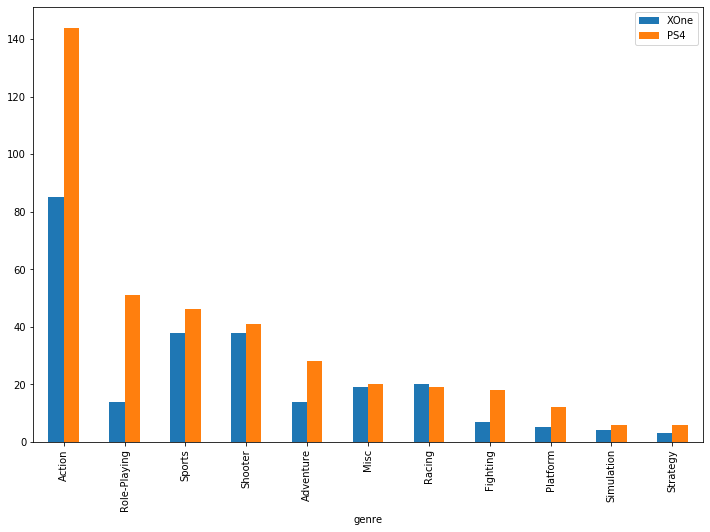

In [53]:
#Количество выпущенных игр по жанрам на XOne
XOne_count = (data[['genre', 'platform']]
 .query('platform=="XOne"')
 .groupby('genre')
 .count())

#Количество выпущенных игр по жанрам на PS4
PS4_count = (data[['genre', 'platform']]
 .query('platform=="PS4"')
 .groupby('genre')
 .count())

#Объеденим данные в одну таблицу
two_count = (XOne_count
             .merge(PS4_count, 
                    left_index=True, 
                    right_index=True))
#Переименуем столбцы
two_count.columns = ['XOne', 'PS4']

#Построим общую гистограмму
(two_count
 .sort_values('PS4', 
              ascending=False)
 .plot(kind='bar', 
       figsize=(12, 8)))

*Количество выпускаемых игр на двух платформах различно, а именно:
 - Самым популярным жанром, среди издательств является Action
 - На PS4 очень популярным является жанр ролевых игр, что на XOne совсем не коррелирует
 - Игры в жанре Sports и Shooter одинаково популярны на двух платформах
 - Так же на PS4 жанр Adventures довольно популярен, что не совсем актуально на XOne*

***

#### *Посмотрим на распределение игр по жанрам на двух платформах по глобальным продажам*

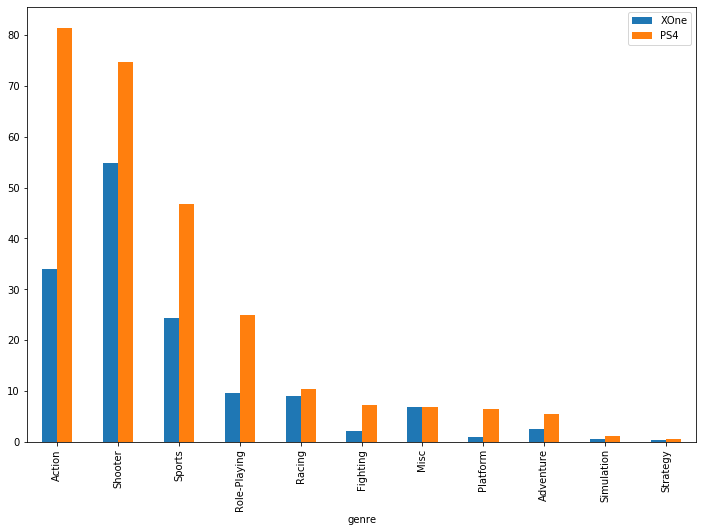

In [54]:
XOne_sum = (data
 .query('platform=="XOne"')
 .pivot_table(index='genre',
              values='global_sales', 
              aggfunc='sum')
 .sort_values('global_sales', 
              ascending=False))

PS4_sum = (data
 .query('platform=="PS4"')
 .pivot_table(index='genre',
              values='global_sales', 
              aggfunc='sum')
 .sort_values('global_sales', 
              ascending=False))

two_sum = (XOne_sum
             .merge(PS4_sum, 
                    left_index=True, 
                    right_index=True))

two_sum.columns = ['XOne', 'PS4']

(two_sum
 .sort_values('PS4', 
              ascending=False)
 .plot(kind='bar', 
       figsize=(12, 8)))

*Ситуация в продажах совсем иная, отличается от картины по выпущенным играм:
 - Самым продаваемым жанром на Ps4 является Action, а вот на XOne - лидер Shooter
 - Стратегии и симуляторы очень плохо продаются на обоих платформах, в дополнение на XOne плохо продаются еще и платформеры с файтингами
 - Игры в жанре Sports, Shooter и Action одинаково популярны на двух платформах, но места в рейтинге распределены по разному
 - Жанр ролевых игр по продажам, так же и как по количеству выпущенных игр, популярен на PS4, но не на XOne.

***
***

## Составим портрет пользователя каждого региона

*Самые популярные платформы (топ-5) в каждом регионе*

In [55]:
top5_platform = (data
                 .query('(platform in @platform_10year_dict or platform=="PS4" or platform=="XOne") and year_of_release>2006')
                 .pivot_table(index='platform', 
                              values=['NA_sales', 
                                      'EU_sales', 
                                      'JP_sales', 
                                      'global_sales'], 
                              aggfunc='sum'))

#ТОП5 на рынке Северной Америки
top5_platform_NA = top5_platform.sort_values('NA_sales', ascending=False).head(5)
top5_platform_NA = top5_platform_NA[['NA_sales']]

#ТОП5 на рынке Европы
top5_platform_EU = top5_platform.sort_values('EU_sales', ascending=False).head(5)
top5_platform_EU = top5_platform_EU[['EU_sales']]

#ТОП5 на рынке Японии
top5_platform_JP = top5_platform.sort_values('JP_sales', ascending=False).head(5)
top5_platform_JP = top5_platform_JP[['JP_sales']]

*Самые популярные жанры (топ-5) в каждом регионе*

In [56]:
top5_genres = (data
                 .query('(platform in @platform_10year_dict or platform=="PS4" or platform=="XOne") and year_of_release>2006')
                 .pivot_table(index='genre', 
                              values=['NA_sales', 
                                      'EU_sales', 
                                      'JP_sales', 
                                      'global_sales'], 
                              aggfunc='sum'))

#ТОП5 на рынке Северной Америки
top5_genres_NA = top5_genres.sort_values('NA_sales', ascending=False).head(5)
top5_genres_NA = top5_genres_NA[['NA_sales']]

#ТОП5 на рынке Европы
top5_genres_EU = top5_genres.sort_values('EU_sales', ascending=False).head(5)
top5_genres_EU = top5_genres_EU[['EU_sales']]

#ТОП5 на рынке Японии
top5_genres_JP = top5_genres.sort_values('JP_sales', ascending=False).head(5)
top5_genres_JP = top5_genres_JP[['JP_sales']]

*Доли продаж в зависимости от рейтинга*

In [57]:
rating_regions = (data
                 .query('(platform in @platform_10year_dict or platform=="PS4" or platform=="XOne") and year_of_release>2006 and rating!=0')
                 .pivot_table(index='rating', 
                              values=['NA_sales', 
                                      'EU_sales', 
                                      'JP_sales', 
                                      'global_sales'], 
                              aggfunc='sum'))

#Распределение продаж от рейтингов на рынке Северной Америки
rating_regions_NA = rating_regions.sort_values('NA_sales', ascending=False).head(5)
rating_regions_NA = rating_regions_NA[['NA_sales']]

#Распределение продаж от рейтингов на рынке Европы
rating_regions_EU = rating_regions.sort_values('EU_sales', ascending=False).head(5)
rating_regions_EU = rating_regions_EU[['EU_sales']]

#Распределение продаж от рейтингов на рынке Японии
rating_regions_JP = rating_regions.sort_values('JP_sales', ascending=False).head(5)
rating_regions_JP = rating_regions_JP[['JP_sales']]

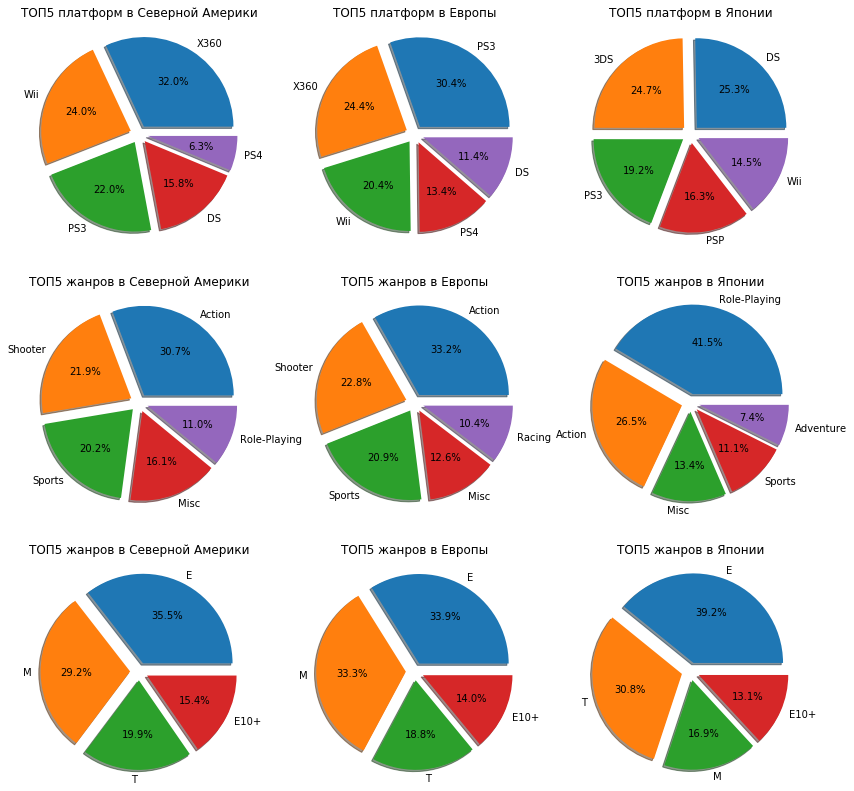

In [58]:
fig, axs = plt.subplots(3, 3, figsize=(14, 14))
#---------------------------------------------------------#
axs[0, 0].set_title('ТОП5 платформ в Северной Америки')
axs[0, 0].pie(top5_platform_NA.NA_sales, 
              labels=top5_platform_NA.index, 
              autopct='%1.1f%%', 
              shadow=True, 
              explode=(0.1, 0.1, 0.1, 0.1, 0.1))

axs[0, 1].set_title('ТОП5 платформ в Европы')
axs[0, 1].pie(top5_platform_EU.EU_sales, 
              labels=top5_platform_EU.index, 
              autopct='%1.1f%%', 
              shadow=True, 
              explode=(0.1, 0.1, 0.1, 0.1, 0.1))

axs[0, 2].set_title('ТОП5 платформ в Японии')
axs[0, 2].pie(top5_platform_JP.JP_sales, 
              labels=top5_platform_JP.index, 
              autopct='%1.1f%%', 
              shadow=True, 
              explode=(0.1, 0.1, 0.1, 0.1, 0.1))
#---------------------------------------------------------#
axs[1, 0].set_title('ТОП5 жанров в Северной Америки')
axs[1, 0].pie(top5_genres_NA.NA_sales, 
              labels=top5_genres_NA.index, 
              autopct='%1.1f%%', 
              shadow=True, 
              explode=(0.1, 0.1, 0.1, 0.1, 0.1))

axs[1, 1].set_title('ТОП5 жанров в Европы')
axs[1, 1].pie(top5_genres_EU.EU_sales, 
              labels=top5_genres_EU.index, 
              autopct='%1.1f%%', 
              shadow=True, 
              explode=(0.1, 0.1, 0.1, 0.1, 0.1))

axs[1, 2].set_title('ТОП5 жанров в Японии')
axs[1, 2].pie(top5_genres_JP.JP_sales, 
              labels=top5_genres_JP.index, 
              autopct='%1.1f%%', 
              shadow=True, 
              explode=(0.1, 0.1, 0.1, 0.1, 0.1))
#---------------------------------------------------------#
axs[2, 0].set_title('ТОП5 жанров в Северной Америки')
axs[2, 0].pie(rating_regions_NA.NA_sales, 
              labels=rating_regions_NA.index, 
              autopct='%1.1f%%', 
              shadow=True, 
              explode=(0.1, 0.1, 0.1, 0.1))

axs[2, 1].set_title('ТОП5 жанров в Европы')
axs[2, 1].pie(rating_regions_EU.EU_sales, 
              labels=rating_regions_EU.index, 
              autopct='%1.1f%%', 
              shadow=True, 
              explode=(0.1, 0.1, 0.1, 0.1))

axs[2, 2].set_title('ТОП5 жанров в Японии')
axs[2, 2].pie(rating_regions_JP.JP_sales, 
              labels=rating_regions_JP.index, 
              autopct='%1.1f%%', 
              shadow=True, 
              explode=(0.1, 0.1, 0.1, 0.1))

plt.show()

#### *Вывод*

*Из данного анализа мы можем сделать следующие выводы:
 - Рынок Северной Америки и Европы очень похож по используемым игровым платформам, в основом это стационарные консоли
 - На рынке в Японии в основном пользуются популярностью мобильные консоли, занимают 2/3 рынка
 - Жанровые предпочтения жителей Европы и Северной Америки практически не отличаются, за одним исключением: в Северной Америке чать пользователей предпочитает ролевые игры, в то время как в Еаропе предпочитают гонки*
 - В Японии преобладают на рынке ролевые игры, занимают почти половину всего рынка, так же значительную долю рынка занимает Action
 - Доля объема продаж игр от рейтингов абсолютно не отличается на рынке Северной Америки и Европы
 - На рынке Японии большую долю в объеме продаж занимают игры для подростков, в то время как в Европе и Северной Америке эту долю занимают игры для взрослых     

***
***

## Проверим статистические гипотезы

### *Средние пользовательские рейтинги платформ Xbox One и PC одинаковые*

*Сформируем нулевую гипотезу:*

**H0 - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые**

**H1 - Средние пользовательские рейтинги платформ Xbox One и PC различаются**

*Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей, нам необходимо взять две выборки и сравнить их между собой с помощью t-критерия Стьюдента.
Определим критический уровень значимости на уровне 5%*

*Так же чтобы применить критерий Стьюдента, сначала убедимся что распределения похожи на нормальные*

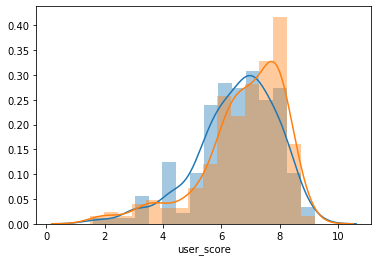

In [59]:
sns.distplot(data.query('platform=="XOne" and user_score>0').user_score, bins=16)
sns.distplot(data.query('platform=="PS4" and user_score>0').user_score, bins=16)

*Распределения похожи на нормальные, можем применить для сравнения t-критерий Стьюдента*

*Для проверки нулевой гипотезы используем метод ttest_ind*

In [60]:
alpha = .05
result = st.ttest_ind(data.query('platform=="XOne" and user_score>0').user_score, 
                      data.query('platform=="PS4" and user_score>0').user_score, 
                      equal_var = False)

print('p-значение:', result.pvalue)
if (result.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.08177132599412448
Не получилось отвергнуть нулевую гипотезу


#### *Результат проверки:*

*При сравнении средних пользовательских рейтингов на платформах PS4 и XOne, с использованием t-критерия Стюдента и критическим уровнем значимости 5%, можно предположить, что средние пользовательские рейтинги различается*

***

### *Средние пользовательские рейтинги жанров Action и Sports разные.*

*Сформируем нулевую гипотезу:*

**H0 - Средние пользовательские рейтинги жанров Action и Sports разные**

**H1 - Средние пользовательские рейтинги жанров Action и Sports одинаковые**

*Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей, нам необходимо взять две выборки и сравнить их между собой с помощью t-критерия Стьюдента.
Определим критический уровень значимости на уровне 5%*

*Так же чтобы применить критерий Стьюдента, сначала убедимся что распределения похожи на нормальные*

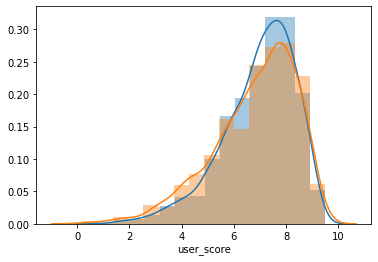

In [61]:
sns.distplot(data.query('genre=="Action" and user_score>0').user_score, bins=16)
sns.distplot(data.query('genre=="Sports" and user_score>0').user_score, bins=16)

*Распределения похожи на нормальные, можем применить для сравнения t-критерий Стьюдента*

*Для проверки нулевой гипотезы используем метод ttest_ind*

In [62]:
alpha = .05
result = st.ttest_ind(data.query('genre=="Action" and user_score>0').user_score, 
                      data.query('genre=="Sports" and user_score>0').user_score, 
                      equal_var = False)

print('p-значение:', result.pvalue)
if (result.pvalue > alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.0030026644249856994
Не получилось отвергнуть нулевую гипотезу


#### *Результат проверки:*

*При сравнении средних пользовательских рейтингов жанров Action и Sports, с использованием t-критерия Стюдента и критическим уровнем значимости 5%, можно предположить, что средние пользовательские рейтинги не различаются*

***
***

### Вывод

*Проведя исследование исходных данных, мы можем сделать следующие выводы:
 - Индустрия компьютерных игр начала активно развиваться с появления на рынке консолей, начиная с середины 90х;
 - Кризис 2008 года сильно ударил по рынку видеоигр, тенденции к восстановлению начали формироваться в 2013 году и продолжаются по сей день;
 - Средний срок жизни игровой платформы - 10 лет;
 - На данный момент на рынке есть только две платформы, которые показывают стабильный рост продаж видеоигр: **PlayStation4** и **Xbox One**, остальные платформы имеют тенденции к снижению уровня продаж и занимают не значительную долю рынка в последние годы;
 - Жанровые и платформенные предпочтения жителей Северной Америки и Европы оочень похожи;
 - Предпочтения жителей Японии в плане выбора платформы смещены в сторону мобильных консолей, а жанровые предпочтения очень сильно ориентированы на ролевые игры.
 - По возрастному рейтингу в Японии большая доля продаж игр для подростков, в то время как в Северной Америке и Европе больше покупают игры для взрослой аудитории.*